<a href="https://colab.research.google.com/github/Lu4nAlmeida/cnm-simnet/blob/main/training_ldpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# Import Dependencies
import torch
import torch.nn as nn
import numpy as np
import pickle as pk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
import time
import copy
import random

In [142]:
# Training Hyperparameters
num_epochs = 1000
learning_rate = 0.001
loss_fn = torch.nn.MSELoss()

# Model Architecture
NUM_HIDDEN_NEURONS = 128
NUM_HIDDEN_LAYERS = 2
in_features = num_dim * 2 + 2  # (vel_x, vel_y, acc_x, acc_y, mass, drg)     2D
out_features = num_dim * 3     # (pos_x, pos_y, vel_x, vel_y, frc_x, frc_y)  2D

In [143]:
# Data Parameters
num_dim = 2
time_step = 0.01
duration = 1.0
simulations = 100

shape = (int(duration / time_step), num_dim)

# Time steps as a NumPy array
delta_times = np.arange(0, duration, time_step)
delta_times = np.broadcast_to(delta_times[:, None], shape)

In [144]:
class ProjectileMotionSimulation:
    def __init__(self, pos, vel, mass, acc, drg):
        self.pos = np.array(pos)
        self.vel = np.array(vel)
        self.mass = mass
        self.acc = np.array(acc)
        self.drg = drg
        self.frc = self.mass * self.acc

    def compute_output(self, initial, time_steps):
        self.pos = self.delta_position(initial.mass, initial.acc, initial.drg, initial.vel, time_steps)
        self.vel = self.final_velocity(initial.mass, initial.acc, initial.drg, initial.vel, time_steps)
        self.frc = self.drag_force(initial.mass, initial.acc, initial.drg, initial.vel, time_steps)

    def random_initial_parameters(self, num_dim, shape):
        self.pos = np.broadcast_to(np.zeros(num_dim), shape),
        self.vel = np.broadcast_to(np.random.uniform(-10, 10, num_dim), shape),
        self.mass = np.full(shape, random.uniform(0, 10)),
        self.acc = np.broadcast_to(np.random.uniform(-10, 10, num_dim), shape),
        self.drg = np.full(shape, random.uniform(0, 5))

    @staticmethod
    def final_velocity(mass, acc, drg, vel, t):
        return (vel - (mass * acc) / drg) * math.e ** (-(drg * t) / mass) + (mass * acc) / drg

    @staticmethod
    def delta_position(mass, acc, drg, vel, t):
        return (mass / drg) * (vel - (mass * acc) / drg) * (1 - math.e ** ((-drg * t) / mass)) + (mass * acc * t) / drg

    @staticmethod
    def drag_force(mass, acc, drg, vel, t=0):
        return -(drg * ProjectileMotionSimulation.final_velocity(mass, acc, drg, vel, t))

In [145]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [146]:
# One-time global fit for scalers
def get_global_scalers(sample_size=10000):
    input_data = []
    output_data = []

    for _ in range(sample_size):
        # Same logic as in generate_data()
        initial = ProjectileMotionSimulation.random_initial_parameters(num_dim, shape)
        final = copy.deepcopy(initial)
        final.compute_output(initial, delta_times)

        inputs = np.concatenate([
            final.vel,
            final.acc,
            final.mass[:, :-1],
            final.drg[:, :-1],
        ], axis=1)
        outputs = np.concatenate([
            final.pos,
            final.vel,
            final.frc
        ], axis=1)

        input_data.append(inputs)
        output_data.append(outputs)

    X = np.array(input_data).reshape(-1, in_features)
    y = np.array(output_data).reshape(-1, out_features)

    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)
    return X_scaler, y_scaler

In [147]:
X_scaler, y_scaler = get_global_scalers(sample_size=2000)

In [148]:
def generate_data(X_scaler, y_scaler, num_simulations=simulations):
    input_data = []
    output_data = []
    runtimes = []

    for _ in range(num_simulations):
        initial = ProjectileMotionSimulation.random_initial_parameters(num_dim, shape)

        final = copy.deepcopy(initial)

        start_time = time.perf_counter()
        final.compute_output(initial, delta_times)
        end_time = time.perf_counter()

        sim_time = end_time - start_time
        runtimes.append(sim_time)

        inputs = np.concatenate([
            final.vel,
            final.acc,
            final.mass[:, :-1],
            final.drg[:, :-1],
        ], axis=1)
        outputs = np.concatenate([
            final.pos,
            final.vel,
            final.frc
        ], axis=1)

        input_data.append(inputs)
        output_data.append(outputs)

    runtimes = np.array(runtimes)
    sim_time = np.mean(runtimes)
    total_time = np.sum(runtimes)

    X = np.array(input_data).reshape(-1, in_features)
    y = np.array(output_data).reshape(-1, out_features)

    X_norm = X_scaler.transform(X).reshape(num_simulations, shape[0], in_features)
    y_norm = y_scaler.transform(y).reshape(num_simulations, shape[0], out_features)

    # Train/test split
    split = int(0.8 * len(X_norm))
    X_train, X_test = X_norm[:split], X_norm[split:]
    y_train, y_test = y_norm[:split], y_norm[split:]

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train, y_train, X_test, y_test, sim_time, total_time

In [149]:
# Create Model
class ProjectileMotionModelRNN(torch.nn.Module):
    def __init__(self, in_dim=in_features, hid_dim=NUM_HIDDEN_NEURONS, num_layers=NUM_HIDDEN_LAYERS, out_dim=out_features, dropout=0.2):
        super().__init__()
        self.rnn = nn.GRU(input_size=in_dim,
                            hidden_size=hid_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hid_dim, out_dim),
        )
    def forward(self, x):
        # x: (batch, seq, in_dim)
        seq_out, _ = self.rnn(x)          # (batch, seq, hid_dim)
        return self.head(seq_out)         # (batch, seq, out_dim)


In [150]:
# Create model and optimizer
model = ProjectileMotionModelRNN().to(device)

In [151]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

[Epoch    0] Train Loss: 1.018496 | Test Loss: 0.903621
[Epoch  100] Train Loss: 0.104666 | Test Loss: 0.075649
[Epoch  200] Train Loss: 0.017834 | Test Loss: 0.012155
[Epoch  300] Train Loss: 0.009534 | Test Loss: 0.006370
[Epoch  400] Train Loss: 0.007197 | Test Loss: 0.007288
[Epoch  500] Train Loss: 0.005764 | Test Loss: 0.005346
[Epoch  600] Train Loss: 0.004804 | Test Loss: 0.002931
[Epoch  700] Train Loss: 0.003418 | Test Loss: 0.002509
[Epoch  800] Train Loss: 0.003705 | Test Loss: 0.001906
[Epoch  900] Train Loss: 0.002796 | Test Loss: 0.002285


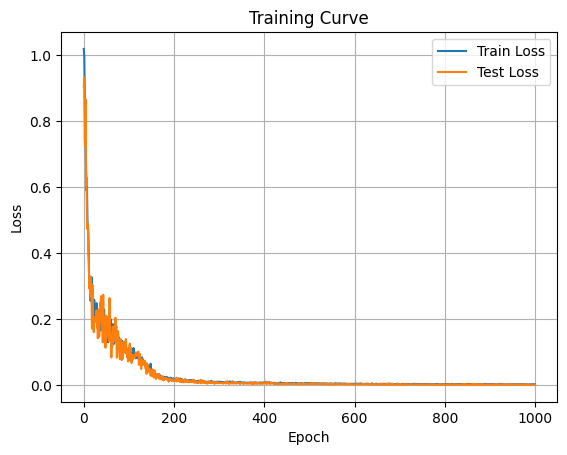

In [152]:
# Training Loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    X_train, y_train, X_test, y_test, *_ = generate_data(X_scaler, y_scaler)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    model.train()

    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Test loss (only one batch)
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test).item()
        test_losses.append(test_loss)

    if epoch % 100 == 0:
        print(f"[Epoch {epoch:>4}] Train Loss: {loss.item():.6f} | Test Loss: {test_loss:.6f}")

# Plot the loss curve
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Curve")
plt.grid(True)
plt.show()

In [153]:
def accuracy(expected, inferred, mode="rmse"):
    if mode == "rmse":
        error = math.sqrt(np.mean((expected - inferred) ** 2))
    elif mode == "mse":
        error = np.mean((expected - inferred) ** 2)
    elif mode == "mae":
        error = np.mean(np.abs(expected - inferred))

    accuracy = 1 / (error + 1)
    return accuracy * 100

In [154]:
# Make inference
sims = 1000
X_train, y_train, X_test, y_test, sim_time, total_time = generate_data(X_scaler, y_scaler, int(sims/0.2))
X_test = X_test.to(device)
y_test = y_test.to(device)

start_time = time.perf_counter()
model.eval()
with torch.no_grad():
  test_pred = model(X_test)
  end_time = time.perf_counter()
  test_pred = test_pred.cpu().numpy()
  y_test = y_test.cpu().numpy()

pred_time = end_time - start_time

In [155]:
# Benchmarks
print(f"Simulations: {y_test.shape[0]}")
print(f"Simulation computed in {sim_time:.9f} seconds.")
print(f"Simulations total time {total_time:.9f} seconds.")
print(f"Simulation inferred in {pred_time:.9f} seconds.\n")

print(f"Accuracy (RMSE): {accuracy(y_test, test_pred,'rmse'):.2f}%")
print(f"Accuracy (MSE): {accuracy(y_test, test_pred, 'mse'):.2f}%")
print(f"Accuracy (MAE): {accuracy(y_test, test_pred, 'mae'):.2f}%")

Simulations: 1000
Simulation computed in 0.000060939 seconds.
Simulations total time 0.304694212 seconds.
Simulation inferred in 0.001232713 seconds.

Accuracy (RMSE): 96.25%
Accuracy (MSE): 99.85%
Accuracy (MAE): 97.81%


In [156]:
sim_times = []
total_times = []
pred_times = []

for num_sims in range(1, 21, 1):
    X_train, y_train, X_test, y_test, sim_time, total_time = generate_data(X_scaler, y_scaler, int(num_sims/0.2))
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    start_time = time.perf_counter()
    model.eval()
    with torch.no_grad():
      test_pred = model(X_test)
      end_time = time.perf_counter()
      test_pred = test_pred.cpu().numpy()
      y_test = y_test.cpu().numpy()

    pred_time = end_time - start_time

    sim_times.append(sim_time)
    total_times.append(total_time)
    pred_times.append(pred_time)
    print(f"Simulations: {num_sims}")

Simulations: 1
Simulations: 2
Simulations: 3
Simulations: 4
Simulations: 5
Simulations: 6
Simulations: 7
Simulations: 8
Simulations: 9
Simulations: 10
Simulations: 11
Simulations: 12
Simulations: 13
Simulations: 14
Simulations: 15
Simulations: 16
Simulations: 17
Simulations: 18
Simulations: 19
Simulations: 20


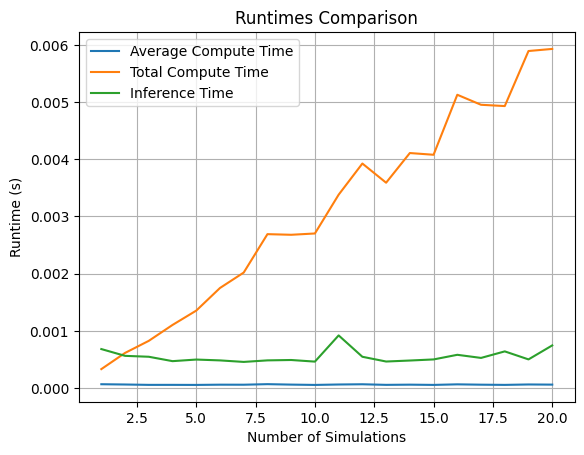

In [157]:
# Plot comparasion graph
plt.plot([i * 1 for i in range(1, len(sim_times) + 1)], sim_times, label="Average Compute Time")
plt.plot([i * 1 for i in range(1, len(total_times) + 1)], total_times, label="Total Compute Time")
plt.plot([i * 1 for i in range(1, len(pred_times) + 1)], pred_times, label="Inference Time")
plt.xlabel("Number of Simulations")
plt.ylabel("Runtime (s)")
plt.legend()
plt.title("Runtimes Comparison")
plt.grid(True)
plt.show()

In [17]:
def simulation_visualization(components, frames=shape[0], color="black"):
    for i in range(frames):
        pos = components[0][i], components[1][i]
        vel = components[2][i], components[3][i]
        frc = components[4][i], components[5][i]

        # Set axis limits dynamically
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)

        if i == 0 or i == 99:
          # Plot velocity and acceleration vectors
          plt.quiver(pos[0], pos[1], frc[0], frc[1], color='orange', scale=15)  # Drag Force
          #plt.quiver(pos[0], pos[1], initial["acc"][0][0], initial["acc"][0][1], color='red', scale=15)  # Acceleration
          plt.quiver(pos[0], pos[1], vel[0]/2, vel[1]/2, color='blue', scale=15)  # Velocity

        # Plot particle position
        plt.scatter(pos[0], pos[1], color=color)

In [18]:
# Reshape the data to 2D before inverse transform
y_shape = y_test.shape
test_pred = test_pred.reshape(-1, test_pred.shape[-1])
y_test = y_test.reshape(-1, y_test.shape[-1])

y_pred = y_scaler.inverse_transform(test_pred)
y_test = y_scaler.inverse_transform(y_test)

# Reshape back to 3D after inverse transform
y_pred = y_pred.reshape(y_shape)
y_test = y_test.reshape(y_shape)

y_pred.shape, y_test.shape

((20, 100, 6), (20, 100, 6))

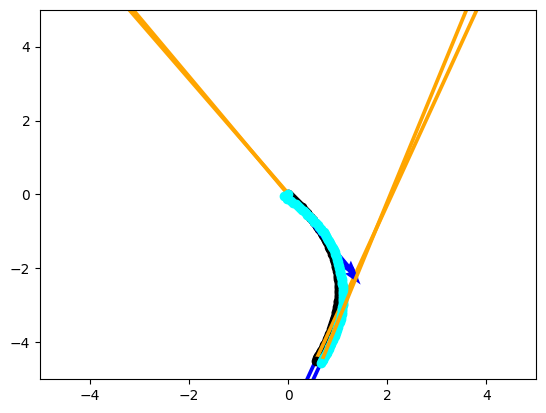

In [19]:
sim = 9

simulation_visualization(y_test[sim].T)
simulation_visualization(y_pred[sim].T, color="cyan")
plt.show()

In [20]:
initial = ProjectileMotionSimulation(
            pos=np.broadcast_to(np.zeros(num_dim), shape),
            vel=np.broadcast_to(np.array([7, 7]), shape),
            mass=np.full(shape, 0.2),
            acc=np.broadcast_to(np.array([0, -9]), shape),
            drg=np.full(shape, 2.6)
        )

initial.compute_output(initial, delta_times)

inputs = np.concatenate([
    initial.vel,
    initial.acc,
    initial.mass[:, :-1],
    initial.drg[:, :-1],
], axis=1)
outputs = np.concatenate([
    initial.pos,
    initial.vel,
    initial.frc
], axis=1)

X = X_scaler.transform(inputs).reshape(1, shape[0], in_features)
y = y_scaler.transform(outputs).reshape(1, shape[0], out_features)

In [21]:
# Make inference
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
  y_pred = model(X)
  y_pred = y_pred.cpu().numpy()
  y = y.cpu().numpy()

In [22]:
# Reshape the data to 2D before inverse transform
y_pred = y_pred.reshape(shape[0], out_features)
y = y.reshape(shape[0], out_features)

y_pred = y_scaler.inverse_transform(y_pred)
y = y_scaler.inverse_transform(y)

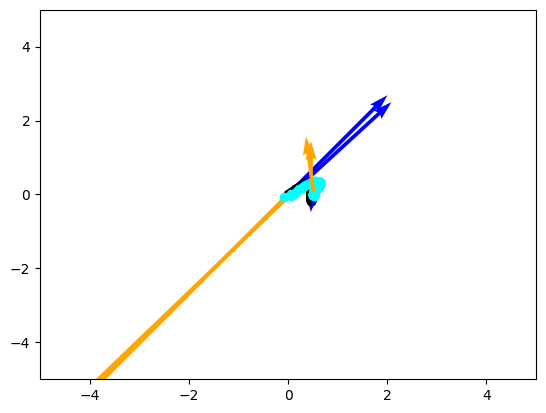

In [23]:
simulation_visualization(y.T)
simulation_visualization(y_pred.T, color="cyan")
plt.show()

In [ ]:
# Saving Model
torch.save(model.state_dict(), "/content/PMmodel_5.pth")
with open("scalers5.pkl", "wb") as f:
    pk.dump((X_scaler, y_scaler), f)